In [1]:
# Plots for basecalling accuracy with lossy compression

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd

In [3]:
compressed_size_dir = '../../data/Klebsiella_pneumoniae_INF032/compressed_size_summary/'
NUM_EXP = 10 # we tried maxerror parameter from 1 to 10

In [4]:
# load compressed sizes and signal lengths into numpy arrays
# array size = number of reads

with open(compressed_size_dir+'/VBZ_lossless.tsv') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    rows = [row for row in reader]
    
signal_lengths = np.array([int(row[1]) for row in rows[1:]],dtype=int)
lossless_sizes = np.array([int(row[2]) for row in rows[1:]],dtype=int)

LFZip_sizes = np.zeros((NUM_EXP,len(lossless_sizes)),dtype=int)
SZ_sizes = np.zeros((NUM_EXP,len(lossless_sizes)),dtype=int)

for i in range(NUM_EXP):
    with open(compressed_size_dir+'/LFZip_maxerror_'+str(i+1)+'.tsv') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        rows = [row for row in reader]
    LFZip_sizes[i,:] = np.array([int(row[2]) for row in rows[1:]],dtype=int)
    
for i in range(NUM_EXP):
    with open(compressed_size_dir+'/SZ_maxerror_'+str(i+1)+'.tsv') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        rows = [row for row in reader]
    SZ_sizes[i,:] = np.array([int(row[2]) for row in rows[1:]],dtype=int)
    

In [5]:
# compute some totals 
signal_lengths_sum = np.sum(signal_lengths)
lossless_sizes_sum = np.sum(lossless_sizes)
LFZip_sizes_sum = np.sum(LFZip_sizes,axis=1)
SZ_sizes_sum = np.sum(SZ_sizes,axis=1)

In [6]:
# Average compression ratio (bytes/signal value) for lossless compression
print('Lossless compression ratio:','{:.3f}'.format((lossless_sizes_sum/signal_lengths_sum)))

Lossless compression ratio: 0.852


In [7]:
# Now load the assembly data
# array size = number of reads
assembly_summary = '../../data/Klebsiella_pneumoniae_INF032/guppy_hac/assembly_summary.tsv'

with open(assembly_summary) as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    rows = [row for row in reader]
    
data_dict = {}
for row in rows[1:]:
    data_dict[row[0]] = row[1:]

assemblers = ['flye','rebaler','medaka']
assembly_num_contigs = {'lossless':{},'LFZip':{},'SZ':{}}
assembly_lengths = {'lossless':{},'LFZip':{},'SZ':{}}
assembly_identity = {'lossless':{},'LFZip':{},'SZ':{}}
for assembler in assemblers:
    assembly_num_contigs['lossless'][assembler] = int(data_dict['lossless_'+assembler][0])
    assembly_lengths['lossless'][assembler] = int(data_dict['lossless_'+assembler][1])
    assembly_identity['lossless'][assembler] = float(data_dict['lossless_'+assembler][2].rstrip('%'))
    
for compressor in ['LFZip','SZ']:
    for assembler in assemblers:
        assembly_num_contigs[compressor][assembler] =\
            np.array([int(data_dict[compressor+'_maxerror_'+str(i+1)+'_'+assembler][0]) for i in range(NUM_EXP)])
        assembly_lengths[compressor][assembler] =\
            np.array([int(data_dict[compressor+'_maxerror_'+str(i+1)+'_'+assembler][1]) for i in range(NUM_EXP)])
        assembly_identity[compressor][assembler] =\
            np.array([float(data_dict[compressor+'_maxerror_'+str(i+1)+'_'+assembler][2].rstrip('%')) for i in range(NUM_EXP)])

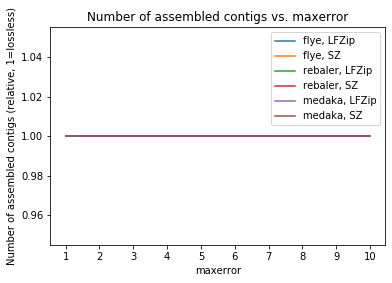

In [8]:
# first verify number of contigs is not affected by the lossy compression
legend = []
for assembler in assemblers:
    for compressor in ['LFZip','SZ']:
        plt.plot(range(1,NUM_EXP+1),assembly_num_contigs[compressor][assembler]/assembly_num_contigs['lossless'][assembler])
        legend.append(assembler+', '+compressor)
plt.legend(legend)
plt.xticks(range(1,NUM_EXP+1))
plt.xlabel('maxerror')
plt.ylabel('Number of assembled contigs (relative, 1=lossless)')
plt.title('Number of assembled contigs vs. maxerror')
plt.savefig('guppy_hac/assembly_num_contigs.pdf',bbox_inches='tight')

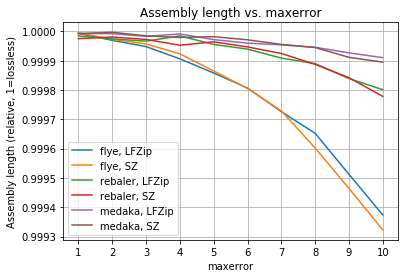

In [9]:
# impact on assembly length 
legend = []
for assembler in assemblers:
    for compressor in ['LFZip','SZ']:
        plt.plot(range(1,NUM_EXP+1),assembly_lengths[compressor][assembler]/assembly_lengths['lossless'][assembler])
        legend.append(assembler+', '+compressor)
plt.legend(legend)
plt.xticks(range(1,NUM_EXP+1))
plt.xlabel('maxerror')
plt.ylabel('Assembly length (relative, 1=lossless)')
plt.title('Assembly length vs. maxerror')
plt.grid()
plt.savefig('guppy_hac/assembly_lengths.pdf',bbox_inches='tight')

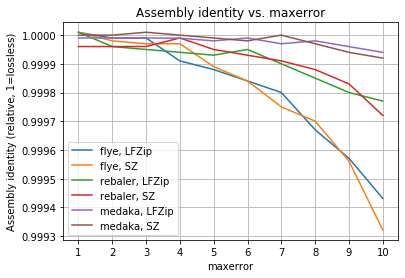

In [10]:
# impact on assembly identity 
legend = []
for assembler in assemblers:
    for compressor in ['LFZip','SZ']:
        plt.plot(range(1,NUM_EXP+1),assembly_identity[compressor][assembler]/assembly_identity['lossless'][assembler])
        legend.append(assembler+', '+compressor)
plt.legend(legend)
plt.xticks(range(1,NUM_EXP+1))
plt.xlabel('maxerror')
plt.ylabel('Assembly identity (relative, 1=lossless)')
plt.title('Assembly identity vs. maxerror')
plt.grid()
plt.savefig('guppy_hac/assembly_identity.pdf',bbox_inches='tight')

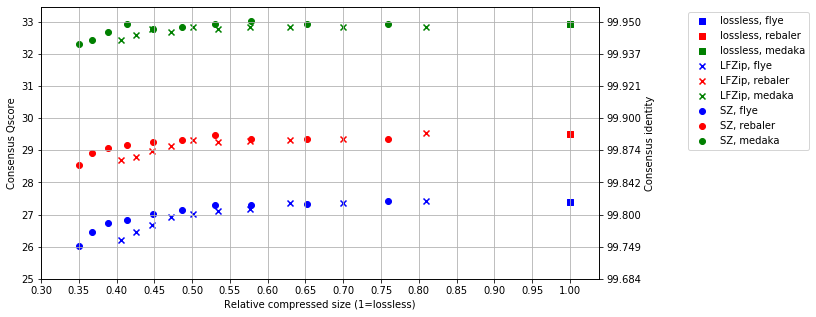

In [12]:
color = {'flye': 'b', 'rebaler': 'r', 'medaka': 'g'}
marker = {'LFZip': 'x', 'SZ': 'o'}
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

# scatter plots
for assembler in assemblers:
    ax_phred.scatter(1.0,phred(assembly_identity['lossless'][assembler]),marker='s',color=color[assembler])
    legend.append('lossless, '+assembler)
for compressor in ['LFZip','SZ']:
    for assembler in assemblers:
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[compressor][assembler]),\
                    color=color[assembler], marker=marker[compressor])
        legend.append(compressor+', '+assembler)
ax_phred.legend(legend,bbox_to_anchor=(1.15,1), loc="upper left")
ax_phred.set_yticks(list(range(25,34)))
percent_ticks = 100-100*np.power(10,-np.array(range(25,34))/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_percent.set_ylabel('Consensus identity')
ax_phred.grid()
plt.savefig('guppy_hac/assembly_rd.pdf',bbox_inches='tight')

In [14]:
# Now load the assembly data (guppy fast)
# array size = number of reads
assembly_summary = '../../data/Klebsiella_pneumoniae_INF032/guppy_fast/assembly_summary.tsv'

with open(assembly_summary) as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    rows = [row for row in reader]
    
data_dict = {}
for row in rows[1:]:
    data_dict[row[0]] = row[1:]

assemblers = ['flye','rebaler','medaka']
assembly_num_contigs = {'lossless':{},'LFZip':{},'SZ':{}}
assembly_lengths = {'lossless':{},'LFZip':{},'SZ':{}}
assembly_identity = {'lossless':{},'LFZip':{},'SZ':{}}
for assembler in assemblers:
    assembly_num_contigs['lossless'][assembler] = int(data_dict['lossless_'+assembler][0])
    assembly_lengths['lossless'][assembler] = int(data_dict['lossless_'+assembler][1])
    assembly_identity['lossless'][assembler] = float(data_dict['lossless_'+assembler][2].rstrip('%'))
    
for compressor in ['LFZip','SZ']:
    for assembler in assemblers:
        assembly_num_contigs[compressor][assembler] =\
            np.array([int(data_dict[compressor+'_maxerror_'+str(i+1)+'_'+assembler][0]) for i in range(NUM_EXP)])
        assembly_lengths[compressor][assembler] =\
            np.array([int(data_dict[compressor+'_maxerror_'+str(i+1)+'_'+assembler][1]) for i in range(NUM_EXP)])
        assembly_identity[compressor][assembler] =\
            np.array([float(data_dict[compressor+'_maxerror_'+str(i+1)+'_'+assembler][2].rstrip('%')) for i in range(NUM_EXP)])

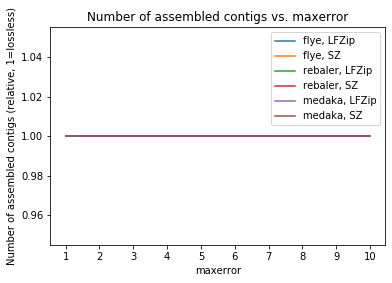

In [15]:
# first verify number of contigs is not affected by the lossy compression
legend = []
for assembler in assemblers:
    for compressor in ['LFZip','SZ']:
        plt.plot(range(1,NUM_EXP+1),assembly_num_contigs[compressor][assembler]/assembly_num_contigs['lossless'][assembler])
        legend.append(assembler+', '+compressor)
plt.legend(legend)
plt.xticks(range(1,NUM_EXP+1))
plt.xlabel('maxerror')
plt.ylabel('Number of assembled contigs (relative, 1=lossless)')
plt.title('Number of assembled contigs vs. maxerror')
plt.savefig('guppy_fast/assembly_num_contigs.pdf',bbox_inches='tight')

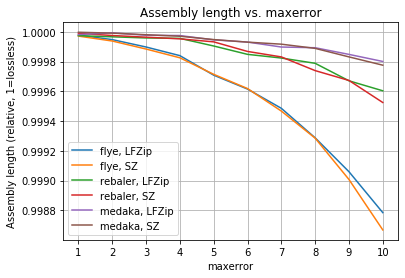

In [16]:
# impact on assembly length 
legend = []
for assembler in assemblers:
    for compressor in ['LFZip','SZ']:
        plt.plot(range(1,NUM_EXP+1),assembly_lengths[compressor][assembler]/assembly_lengths['lossless'][assembler])
        legend.append(assembler+', '+compressor)
plt.legend(legend)
plt.xticks(range(1,NUM_EXP+1))
plt.xlabel('maxerror')
plt.ylabel('Assembly length (relative, 1=lossless)')
plt.title('Assembly length vs. maxerror')
plt.grid()
plt.savefig('guppy_fast/assembly_lengths.pdf',bbox_inches='tight')

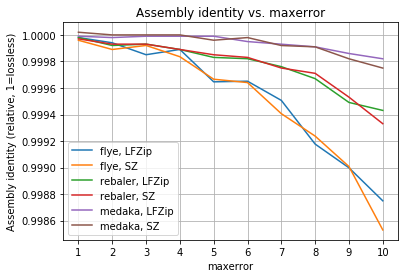

In [17]:
# impact on assembly identity 
legend = []
for assembler in assemblers:
    for compressor in ['LFZip','SZ']:
        plt.plot(range(1,NUM_EXP+1),assembly_identity[compressor][assembler]/assembly_identity['lossless'][assembler])
        legend.append(assembler+', '+compressor)
plt.legend(legend)
plt.xticks(range(1,NUM_EXP+1))
plt.xlabel('maxerror')
plt.ylabel('Assembly identity (relative, 1=lossless)')
plt.title('Assembly identity vs. maxerror')
plt.grid()
plt.savefig('guppy_fast/assembly_identity.pdf',bbox_inches='tight')

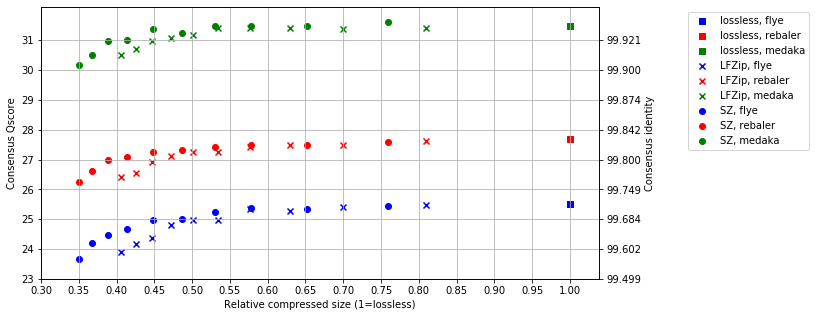

In [19]:
color = {'flye': 'b', 'rebaler': 'r', 'medaka': 'g'}
marker = {'LFZip': 'x', 'SZ': 'o'}
compressed_sizes = {'LFZip': LFZip_sizes_sum/lossless_sizes_sum, 'SZ': SZ_sizes_sum/lossless_sizes_sum}
legend = []

def phred(x):
    return -10*np.log10((100-x)/100)
    
_,ax_phred = plt.subplots(figsize=(10,5))
ax_percent = ax_phred.twinx()

# scatter plots
for assembler in assemblers:
    ax_phred.scatter(1.0,phred(assembly_identity['lossless'][assembler]),marker='s',color=color[assembler])
    legend.append('lossless, '+assembler)
for compressor in ['LFZip','SZ']:
    for assembler in assemblers:
        ax_phred.scatter(compressed_sizes[compressor],\
                    phred(assembly_identity[compressor][assembler]),\
                    color=color[assembler], marker=marker[compressor])
        legend.append(compressor+', '+assembler)
ax_phred.legend(legend,bbox_to_anchor=(1.15,1), loc="upper left")
ax_phred.set_yticks(list(range(23,32)))
percent_ticks = 100-100*np.power(10,-np.array(range(23,32))/10)
percent_ticks_str = ['{:.3f}'.format(val) for val in percent_ticks]
ax_percent.set_ylim(ax_phred.get_ylim())
ax_percent.set_yticks(ax_phred.get_yticks())
ax_percent.set_yticklabels(percent_ticks_str)
ax_phred.set_xticks(np.arange(0.3,1.05,0.05))
ax_phred.set_xlabel('Relative compressed size (1=lossless)')
ax_phred.set_ylabel('Consensus Qscore')
ax_percent.set_ylabel('Consensus identity')
ax_phred.grid()
plt.savefig('guppy_fast/assembly_rd.pdf',bbox_inches='tight')